In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/statoil-iceberg-classifier-challenge/train.json.7z
/kaggle/input/statoil-iceberg-classifier-challenge/test.json.7z
/kaggle/input/statoil-iceberg-classifier-challenge/sample_submission.csv.7z


In [2]:
!pip install pyunpack
!pip install patool
os.system('apt-get install p7zip')
import os
from pyunpack import Archive
import shutil
if not os.path.exists('/kaggle/working/data'):
    os.makedirs('/kaggle/working/data')
Archive('/kaggle/input/statoil-iceberg-classifier-challenge/test.json.7z').extractall('/kaggle/working/data/')
Archive('/kaggle/input/statoil-iceberg-classifier-challenge/train.json.7z').extractall('/kaggle/working/data/')
for dirname, _, filenames in os.walk('/kaggle/working/test/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 77 kB 665 kB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
base_path = 'data/processed/'
def load_and_format(in_path):
    out_df = pd.read_json(in_path)
    out_images = out_df.apply(lambda c_row: [np.stack([c_row['band_1'],c_row['band_2']], -1).reshape((75,75,2))],1)
    out_images = np.stack(out_images).squeeze()
    return out_df, out_images

train_df, train_images = load_and_format(os.path.join('', '../working/data/data/processed/train.json'))
test_df, test_images = load_and_format(os.path.join('', "../working/data/data/processed/test.json"))

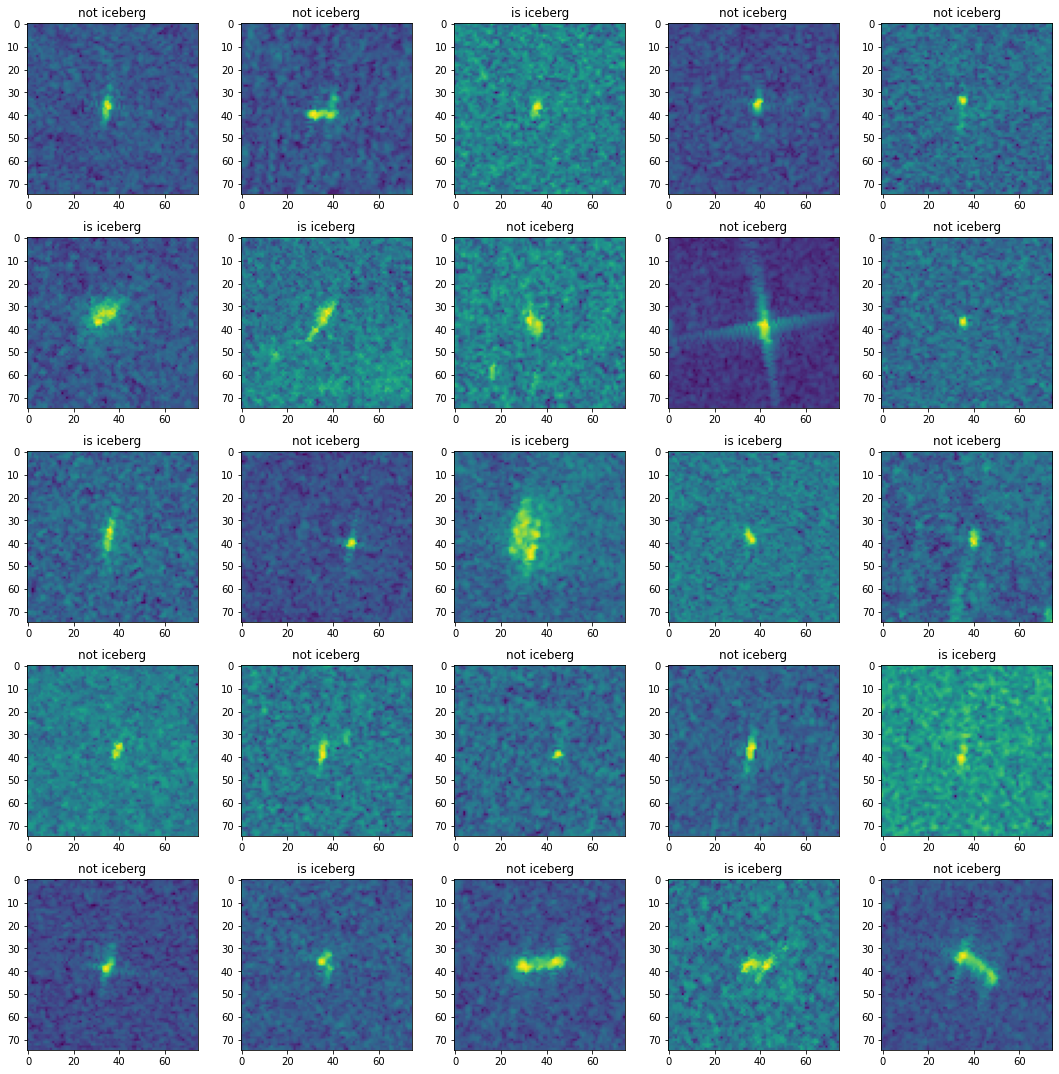

In [4]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# settings
h, w = 50, 50        # for raster image
nrows, ncols = 5, 5  # array of sub-plots
figsize = [15, 15]     # figure size, inches

# prep (x,y) for extra plotting on selected sub-plots
xs = np.linspace(0, 2*np.pi, 60)  # from 0 to 2pi
ys = np.abs(np.sin(xs))           # absolute of sine

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

df = train_df #.loc[train_df.is_iceberg == 1].reset_index(drop=True)

# plot simple raster image on each sub-plot
for i, axi in enumerate(ax.flat):
    # i runs from 0 to (nrows*ncols-1)
    # axi is equivalent with ax[rowid][colid]
    img1 = df['band_1'][i]
    img = np.array(img1).reshape(75, 75)
    axi.imshow(img)
    # get indices of row/column
    rowid = i // ncols
    colid = i % ncols
    
    # write row/col indices as axes' title for identification
    if(df['is_iceberg'][i] == 1):
        axi.set_title('is iceberg')
    else:
        axi.set_title('not iceberg')


plt.tight_layout(True)
plt.show()

Different preprocessing methods

In [5]:
from scipy.ndimage import gaussian_filter
from skimage.morphology import reconstruction
##ROF去噪
def denoise_rof(im, U_init, tolerance=0.1, tau=0.125, tv_weight=100):
    """ An implementation of the Rudin-Osher-Fatemi (ROF) denoising model
        using the numerical procedure presented in Eq. (11) of A. Chambolle
        (2005). Implemented using periodic boundary conditions 
        (essentially turning the rectangular image domain into a torus!).
    
        Input:
        im - noisy input image (grayscale)
        U_init - initial guess for U
        tv_weight - weight of the TV-regularizing term
        tau - steplength in the Chambolle algorithm
        tolerance - tolerance for determining the stop criterion
    
        Output:
        U - denoised and detextured image (also the primal variable)
        T - texture residual"""
    
    #---Initialization
    m,n = im.shape #size of noisy image

    U = U_init
    Px = im #x-component to the dual field
    Py = im #y-component of the dual field
    error = 1 
    iteration = 0

    #---Main iteration
    while (error > tolerance):
        Uold = U

        #Gradient of primal variable
        LyU = np.vstack((U[1:,:],U[0,:])) #Left translation w.r.t. the y-direction
        LxU = np.hstack((U[:,1:],U.take([0],axis=1))) #Left translation w.r.t. the x-direction

        GradUx = LxU-U #x-component of U's gradient
        GradUy = LyU-U #y-component of U's gradient

        #First we update the dual varible
        PxNew = Px + (tau/tv_weight)*GradUx #Non-normalized update of x-component (dual)
        PyNew = Py + (tau/tv_weight)*GradUy #Non-normalized update of y-component (dual)
        NormNew = np.maximum(1,np.sqrt(PxNew**2+PyNew**2))

        Px = PxNew/NormNew #Update of x-component (dual)
        Py = PyNew/NormNew #Update of y-component (dual)

        #Then we update the primal variable
        RxPx =np.hstack((Px.take([-1],axis=1),Px[:,0:-1])) #Right x-translation of x-component
        RyPy = np.vstack((Py[-1,:],Py[0:-1,:])) #Right y-translation of y-component
        DivP = (Px-RxPx)+(Py-RyPy) #Divergence of the dual field.
        U = im + tv_weight*DivP #Update of the primal variable

        #Update of error-measure
        error = np.linalg.norm(U-Uold)/np.sqrt(n*m);
        iteration += 1;

    #The texture residual
#    T = im - U
    
    return U
##形态学
def transform(img):

    img=gaussian_filter(img,2.5)
    seed=np.copy(img)
    seed[1:-1,1:-1]=img.min()
    mask=img
    ##morphology processing
    pro_img=reconstruction(seed,mask,method="dilation")
    return img-pro_img
def switchPreProcessing(band1,band2,angl,mode="01"):
    if mode=="01":        
        X_band_3=np.array([(band-np.min(band))/(np.max(band)-np.min(band)) for band in band1])
        X_band_4=np.array([(band-np.min(band))/(np.max(band)-np.min(band)) for band in band2])
        X_band_5=np.fabs(np.subtract(X_band_3,X_band_4))
    elif mode=="02":
        X_band_3=np.fabs(np.subtract(band1,band2))
        X_band_4=np.maximum(band1,band2)
        X_band_5=np.minimum(band1,band2)
    elif mode=="03":
        x_band_temp=band1+band2
        X_band_3=np.array([(band-np.mean(band)/(np.max(band)-np.min(band))) for band in band1])
        X_band_4=np.array([(band-np.mean(band)/(np.max(band)-np.min(band))) for band in band2])
        X_band_5=np.array([(band-np.mean(band)/(np.max(band)-np.min(band))) for band in x_band_temp])
    elif mode=="04":
        x_band_temp=band1+band2
        
        X_band_3=np.array([(band-np.min(band)/(np.max(band)-np.min(band))) for band in band1])
        X_band_4=np.array([(band-np.min(band)/(np.max(band)-np.min(band))) for band in band2])
        X_band_5=np.array([(band-np.min(band)/(np.max(band)-np.min(band))) for band in x_band_temp])
    elif mode=="05":##Fourier Transform
        x_band_temp=band1+band2
        X_band_3=np.array([np.abs(np.fft.ifft2(np.fft.ifftshift(np.fft.fftshift(np.fft.fft2((band-np.min(band))/(np.max(band)-np.min(band))))))) for band in band1])
        X_band_4=np.array([np.abs(np.fft.ifft2(np.fft.ifftshift(np.fft.fftshift(np.fft.fft2((band-np.min(band))/(np.max(band)-np.min(band))))))) for band in band2])
        X_band_5=np.array([np.abs(np.fft.ifft2(np.fft.ifftshift(np.fft.fftshift(np.fft.fft2((band-np.min(band))/(np.max(band)-np.min(band))))))) for band in x_band_temp])
    elif mode=="06":##ROF denoise
        x_band_temp=band1+band2
        X_band_3=np.array([denoise_rof((band-np.min(band))/(np.max(band)-np.min(band)),(band-np.min(band))/(np.max(band)-np.min(band))) for band in band1])
        X_band_4=np.array([denoise_rof((band-np.min(band))/(np.max(band)-np.min(band)),(band-np.min(band))/(np.max(band)-np.min(band))) for band in band2])
        X_band_5=np.array([denoise_rof((band-np.min(band))/(np.max(band)-np.min(band)),(band-np.min(band))/(np.max(band)-np.min(band))) for band in x_band_temp])      
    elif mode=="07":## ROF denoise + fourier transform
        x_band_temp=band1+band2
        X_band_3_temp=np.array([denoise_rof((band-np.min(band))/(np.max(band)-np.min(band)),(band-np.min(band))/(np.max(band)-np.min(band))) for band in band1])
        X_band_4_temp=np.array([denoise_rof((band-np.min(band))/(np.max(band)-np.min(band)),(band-np.min(band))/(np.max(band)-np.min(band))) for band in band2])
        X_band_5_temp=np.array([denoise_rof((band-np.min(band))/(np.max(band)-np.min(band)),(band-np.min(band))/(np.max(band)-np.min(band))) for band in x_band_temp])      

        X_band_3=np.array([np.abs(np.fft.ifft2(np.fft.ifftshift(np.fft.fftshift(np.fft.fft2((band-np.min(band))/(np.max(band)-np.min(band))))))) for band in X_band_3_temp])
        X_band_4=np.array([np.abs(np.fft.ifft2(np.fft.ifftshift(np.fft.fftshift(np.fft.fft2((band-np.min(band))/(np.max(band)-np.min(band))))))) for band in X_band_4_temp])
        X_band_5=np.array([np.abs(np.fft.ifft2(np.fft.ifftshift(np.fft.fftshift(np.fft.fft2((band-np.min(band))/(np.max(band)-np.min(band))))))) for band in X_band_5_temp])   
    elif mode=="08":## Fourier transform + ROF denoise
        x_band_temp=band1+band2
        X_band_3_temp=np.array([np.abs(np.fft.ifft2(np.fft.ifftshift(np.fft.fftshift(np.fft.fft2((band-np.min(band))/(np.max(band)-np.min(band))))))) for band in band1])
        X_band_4_temp=np.array([np.abs(np.fft.ifft2(np.fft.ifftshift(np.fft.fftshift(np.fft.fft2((band-np.min(band))/(np.max(band)-np.min(band))))))) for band in band2])
        X_band_5_temp=np.array([np.abs(np.fft.ifft2(np.fft.ifftshift(np.fft.fftshift(np.fft.fft2((band-np.min(band))/(np.max(band)-np.min(band))))))) for band in x_band_temp])        
        
        X_band_3=np.array([denoise_rof((band-np.min(band))/(np.max(band)-np.min(band)),(band-np.min(band))/(np.max(band)-np.min(band))) for band in X_band_3_temp])
        X_band_4=np.array([denoise_rof((band-np.min(band))/(np.max(band)-np.min(band)),(band-np.min(band))/(np.max(band)-np.min(band))) for band in X_band_4_temp])
        X_band_5=np.array([denoise_rof((band-np.min(band))/(np.max(band)-np.min(band)),(band-np.min(band))/(np.max(band)-np.min(band))) for band in X_band_5_temp])   
    elif mode=="09":## Morphological Transformations
        x_band_temp=band1+band2
        
        X_band_3_temp=np.array([transform(band) for band in band1])
        X_band_4_temp=np.array([transform(band) for band in band2])
        X_band_5_temp=np.array([transform(band) for band in x_band_temp])      
        
        X_band_3=np.array([(band-np.min(band))/(np.max(band)-np.min(band)) for band in X_band_3_temp])
        X_band_4=np.array([(band-np.min(band))/(np.max(band)-np.min(band)) for band in X_band_4_temp])
        X_band_5=np.array([(band-np.min(band))/(np.max(band)-np.min(band)) for band in X_band_5_temp])
        
        
    X_train_ = np.concatenate([X_band_3[:, :, :, np.newaxis],X_band_4[:, :, :, np.newaxis],X_band_5[:, :, :, np.newaxis]], axis=-1)
    X_train_angle_ = np.concatenate([X_band_3[:, :, :, np.newaxis],X_band_4[:, :, :, np.newaxis],angl[:, :, :, np.newaxis]], axis=-1)
    
    return X_band_3,X_band_4,X_band_5,X_train_,X_train_angle_


In [6]:
train = pd.read_json("./data/data/processed/train.json")
target_train=train
test = pd.read_json("./data/data/processed/test.json")

train['inc_angle']=pd.to_numeric(train['inc_angle'], errors='coerce')
train['inc_angle']=train['inc_angle'].fillna(method='pad')
X_angle=train['inc_angle']

test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
X_test_angle=test['inc_angle']

In [7]:
import matplotlib.pyplot as plt

def show_demo_pics(X_band_3,X_band_4,X_band_5,X_train, X_train_angle, mode, plotnum):
    plt.subplots(15,figsize=(15,15))
    plt.subplot(151)
    plt.title('Preprocess mode: ' + str(mode))
    plt.imshow(X_band_3[plotnum])
    plt.subplot(152)
    plt.imshow(X_band_4[plotnum])
    plt.subplot(153)
    plt.imshow(X_band_5[plotnum])
    plt.subplot(154)
    plt.imshow(X_train[plotnum])
    plt.subplot(155)
    plt.imshow(X_train_angle[plotnum])
    plt.show()

In [8]:
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])

means=(-22.159262, -24.953745, 40.021883465782651)
stds=(5.33146, 4.5463958, 4.0815391476694414)
angl = train['inc_angle'].map(lambda x: np.cos(x * np.pi / 180) if x != 'na' else means[2])
angl = np.array([np.full(shape=(75, 75), fill_value=angel).astype(np.float32) for angel in angl])
angl = (angl - means[2]) / stds[2]

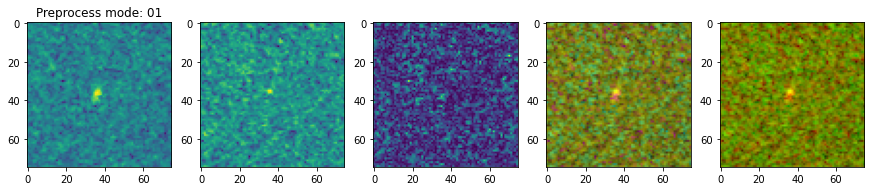

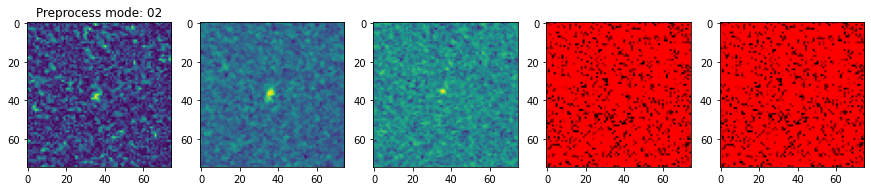

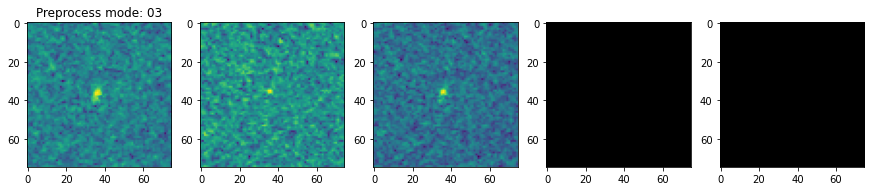

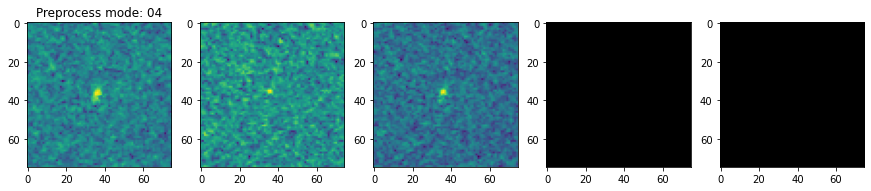

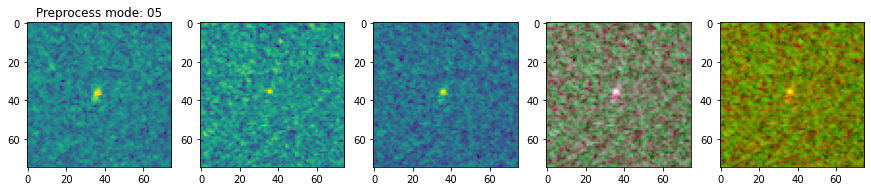

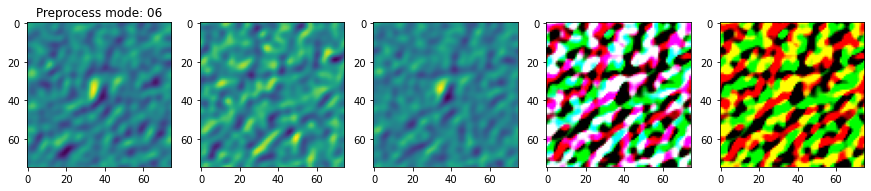

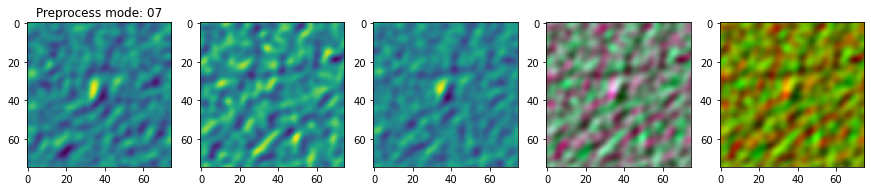

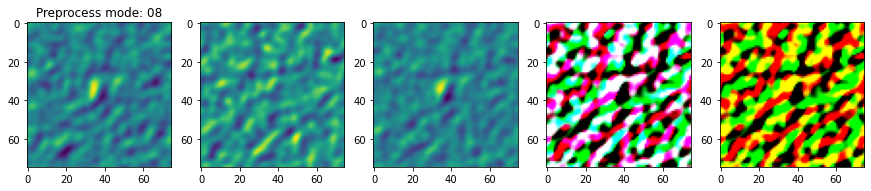

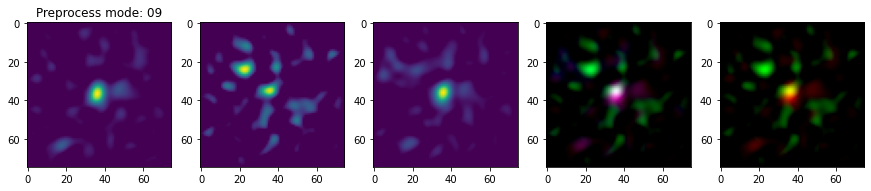

In [9]:
for i in range(1,10):
    preprocess_mode= '0' + str(i)
    X_band_3,X_band_4,X_band_5,X_train,X_train_angle=switchPreProcessing(X_band_1,X_band_2,angl,mode=preprocess_mode)
    show_demo_pics(X_band_3,X_band_4,X_band_5,X_train, X_train_angle,preprocess_mode, 2)

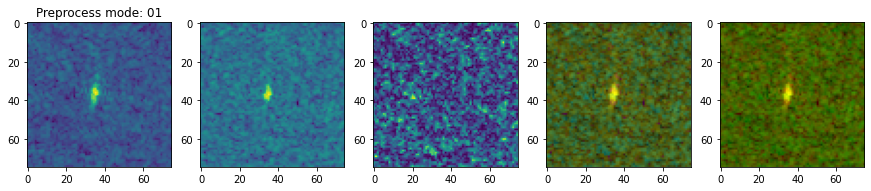

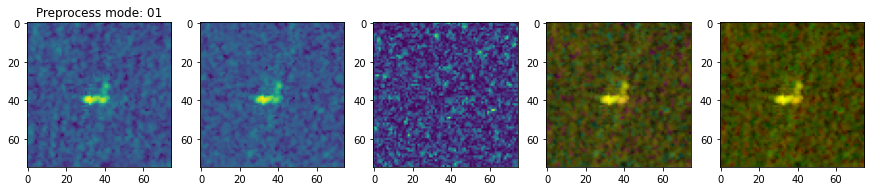

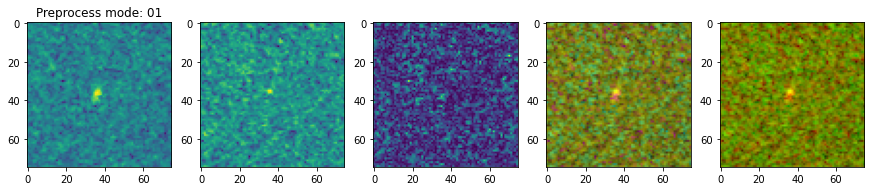

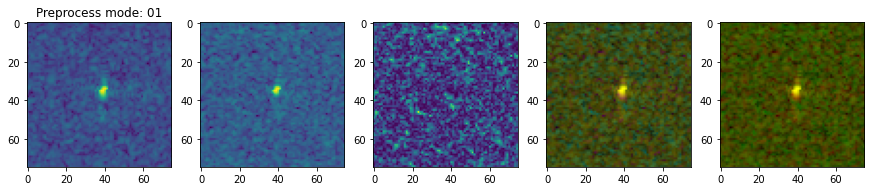

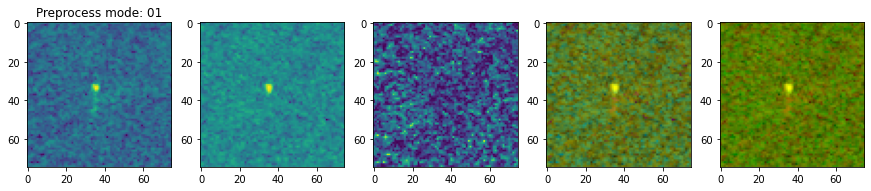

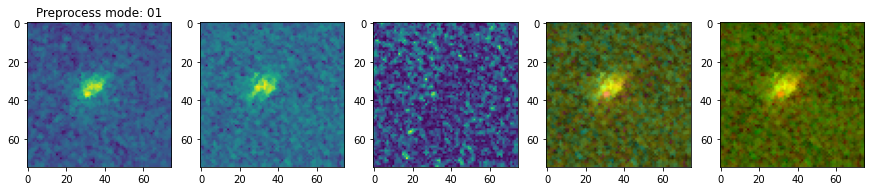

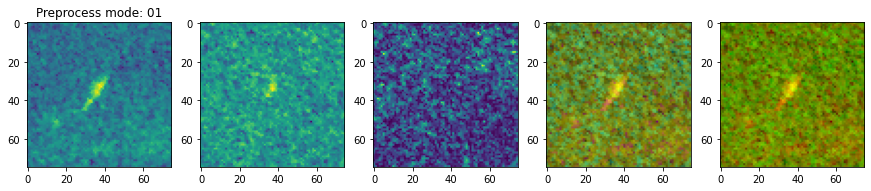

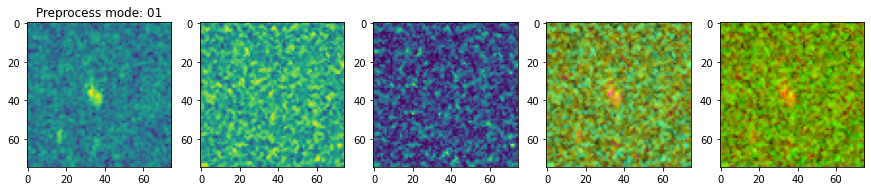

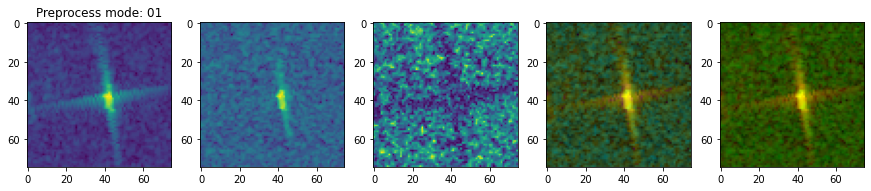

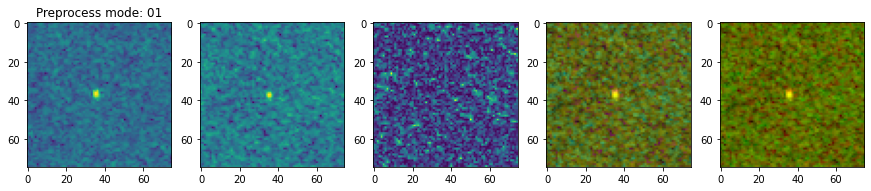

In [10]:
mode='01'
X_band_3,X_band_4,X_band_5,X_train,X_train_angle=switchPreProcessing(X_band_1,X_band_2,angl,mode=mode)
for i in range (10):
    show_demo_pics(X_band_3,X_band_4,X_band_5,X_train, X_train_angle,mode,i)

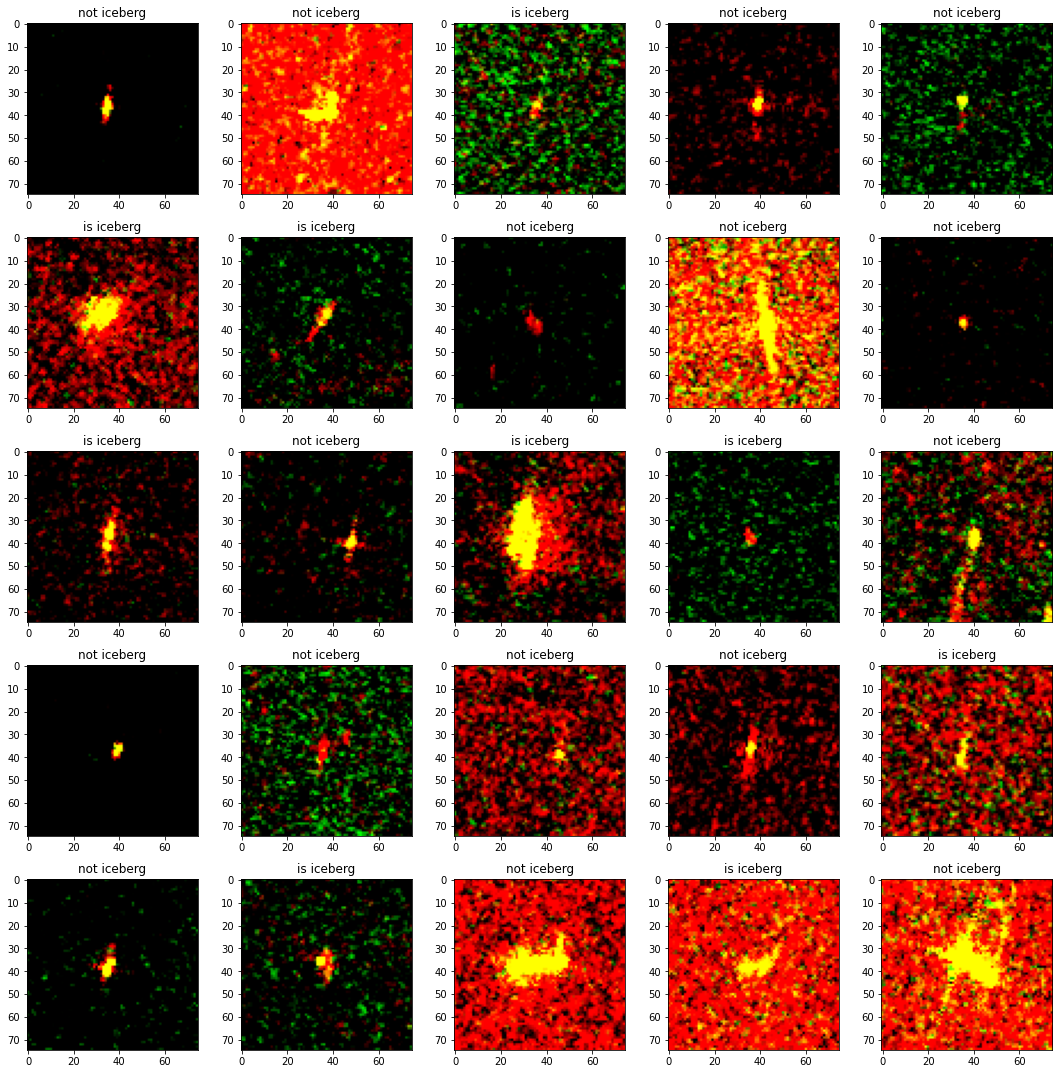

In [11]:
means=(-22.159262, -24.953745, 40.021883465782651)
stds=(5.33146, 4.5463958, 4.0815391476694414)
X_band_1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) 
                     for band in train["band_1"]])
X_band_2 = np.array([np.array(band).astype(np.float32).reshape(75, 75)
                     for band in train["band_2"]])

angl = train['inc_angle'].map(lambda x: np.cos(x * np.pi / 180) if x != 'na' else means[2])
angl = np.array([np.full(shape=(75, 75), fill_value=angel).astype(np.float32)
                 for angel in angl])

X_band_1 = (X_band_1 - means[0]) / stds[0]
X_band_2 = (X_band_2 - means[1]) / stds[1]
angl = (angl - means[2]) / stds[2]

images = np.concatenate([X_band_1[:, :, :, np.newaxis],
                         X_band_2[:, :, :, np.newaxis],
                         angl[:, :, :, np.newaxis]],
                        axis=-1)

# settings
h, w = 50, 50        # for raster image
nrows, ncols = 5, 5  # array of sub-plots
figsize = [15, 15]     # figure size, inches

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

# plot simple raster image on each sub-plot
for i, axi in enumerate(ax.flat):
    axi.imshow(images[i])
    if(train['is_iceberg'][i] == 1):
        axi.set_title('is iceberg')
    else:
        axi.set_title('not iceberg')


plt.tight_layout(True)
plt.show()